In [1]:
pip install torch torchvision clip-by-openai pillow matplotlib tqdm


  Using cached clip_by_openai-1.1-py3-none-any.whl.metadata (369 bytes)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached clip_by_openai-1.0.1-py3-none-any.whl.metadata (407 bytes)
  Using cached clip_by_openai-0.1.1.5-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.4-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.3-py3-none-any.whl.metadata (8.7 kB)
  Using cached clip_by_openai-0.1.1.2-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.1-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.0-py3-none-any.whl.metadata (9.0 kB)
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached torchvision-0.22.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (6.1 kB)
  Using cached torch-2

In [2]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y_knhjqg
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y_knhjqg
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


# ***MANUAL PROMPT APPROACH*** 


Test images: 1670
Computing test image features...


100%|██████████| 53/53 [00:15<00:00,  3.41it/s]



Enter your prompt (or type 'exit' to quit):  a photo of elephant


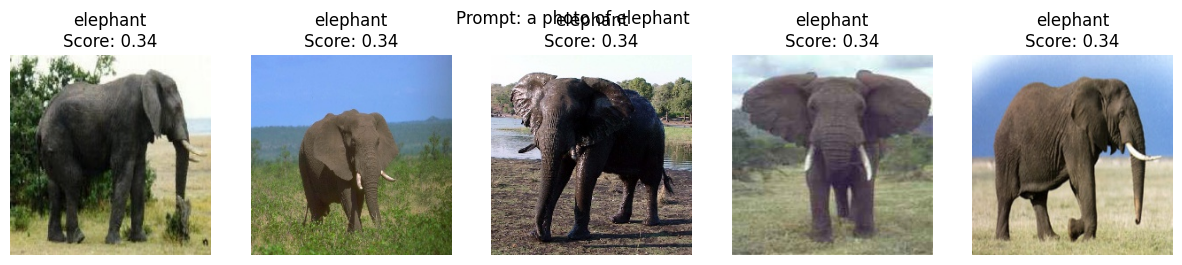


Enter your prompt (or type 'exit' to quit):  exit


In [3]:
import os
import torch
from torchvision import transforms
from PIL import Image
import clip
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Paths and constants
PACS_ROOT = "/kaggle/input/pacs-dataset/kfold"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Set your train and test domains here:
TRAIN_DOMAINS = ["cartoon", "sketch", "art_painting"]
TEST_DOMAIN = "photo"

# Load CLIP
model, preprocess = clip.load("ViT-B/32", device=DEVICE)

def index_pacs_images(root, domains):
    image_paths, image_labels = [], []
    for domain in domains:
        for cls in CLASSES:
            dir_path = os.path.join(root, domain, cls)
            if not os.path.exists(dir_path):
                continue
            for fname in os.listdir(dir_path):
                if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(dir_path, fname))
                    image_labels.append(cls)
    return image_paths, image_labels

def compute_image_features(image_paths, batch_size=32):
    all_features = []
    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size)):
            batch_paths = image_paths[i:i+batch_size]
            images = [preprocess(Image.open(p).convert("RGB")) for p in batch_paths]
            images = torch.stack(images).to(DEVICE)
            feats = model.encode_image(images)
            feats /= feats.norm(dim=-1, keepdim=True)
            all_features.append(feats.cpu())
    return torch.cat(all_features, dim=0)

def retrieve_and_show_images(prompt, image_features, image_paths, image_labels, top_k=5):
    text = clip.tokenize([prompt]).to(DEVICE)
    with torch.no_grad():
        text_features = model.encode_text(text)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        sims = (image_features @ text_features.T).squeeze(1)
        topk_indices = sims.topk(top_k).indices.cpu().numpy()
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(topk_indices):
        img = Image.open(image_paths[idx])
        plt.subplot(1, top_k, i+1)
        plt.imshow(img)
        plt.title(f"{image_labels[idx]}\nScore: {sims[idx]:.2f}")
        plt.axis("off")
    plt.suptitle(f"Prompt: {prompt}")
    plt.show()

# Index and compute features for test domain images only
test_images, test_labels = index_pacs_images(PACS_ROOT, [TEST_DOMAIN])
print(f"Test images: {len(test_images)}")
print("Computing test image features...")
test_image_features = compute_image_features(test_images)
test_image_features = test_image_features.to(DEVICE)

# Prompt-based retrieval loop
while True:
    prompt = input("\nEnter your prompt (or type 'exit' to quit): ")
    if prompt.lower() == 'exit':
        break
    retrieve_and_show_images(prompt, test_image_features, test_images, test_labels, top_k=5)


# SOFT PROMPT GENERATION FOR DOMAIN GENERALIZATION 

In [6]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
from transformers import CLIPProcessor, CLIPModel

# ==== CONFIGURATION ====
PACS_ROOT = "/kaggle/input/pacs-dataset/kfold"
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
TRAIN_DOMAINS = ["art_painting", "cartoon", "sketch"]
TEST_DOMAIN = "photo"
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5  # Increase for real use

# ==== DATASET LOADING ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def get_domain_dataset(domain):
    domain_path = os.path.join(PACS_ROOT, domain)
    return datasets.ImageFolder(domain_path, transform=transform)

train_datasets = [get_domain_dataset(d) for d in TRAIN_DOMAINS]
train_dataset = ConcatDataset(train_datasets)
test_dataset = get_domain_dataset(TEST_DOMAIN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==== CLIP BACKBONE ====
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_model.eval()

# ==== CLASSIFIER ON TOP OF CLIP ====
class ClipClassifier(nn.Module):
    def __init__(self, feature_dim=512, num_classes=7):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

classifier = ClipClassifier().to(DEVICE)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ==== TRAINING LOOP ====
for epoch in range(EPOCHS):
    classifier.train()
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).long()  # Ensure labels are integer class indices

        with torch.no_grad():
            image_features = clip_model.get_image_features(images)

        logits = classifier(image_features)  # [batch_size, num_classes]
        loss = criterion(logits, labels)     # [batch_size], long

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# ==== EVALUATION ====
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).long()
        image_features = clip_model.get_image_features(images)
        logits = classifier(image_features)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test accuracy on domain '{TEST_DOMAIN}': {100. * correct / total:.2f}%")


Epoch 1/5, Loss: 0.0090
Epoch 2/5, Loss: 0.0032
Epoch 3/5, Loss: 2.5017
Epoch 4/5, Loss: 0.0082
Epoch 5/5, Loss: 0.0150
Test accuracy on domain 'photo': 99.76%


# SOFT PROMPT GENRATION FOR DG WITH VISUALS (PROMPT GIVEN)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 1/3, Loss: 0.1167


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 2/3, Loss: 0.0030


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch 3/3, Loss: 0.5848


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Test accuracy on domain 'photo': 99.40%


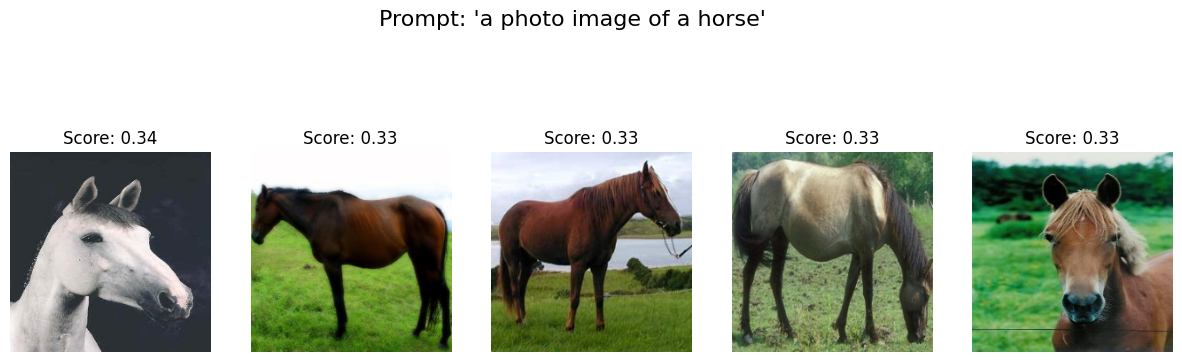

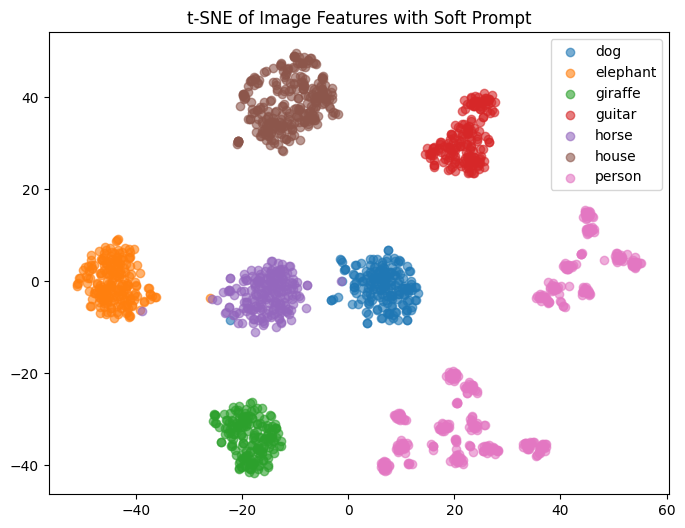

In [9]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets, transforms
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np

# ==== CONFIGURATION ====
PACS_ROOT = "/kaggle/input/pacs-dataset/kfold"
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
TRAIN_DOMAINS = ["art_painting", "cartoon", "sketch"]
TEST_DOMAIN = "photo"
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 3  # For demo; increase for real use
PROMPT_LEN = 4
EMBED_DIM = 512

# ==== DATASET LOADING ====
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def get_domain_dataset(domain):
    domain_path = os.path.join(PACS_ROOT, domain)
    return datasets.ImageFolder(domain_path, transform=transform)

train_datasets = [get_domain_dataset(d) for d in TRAIN_DOMAINS]
train_dataset = ConcatDataset(train_datasets)
test_dataset = get_domain_dataset(TEST_DOMAIN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ==== CLIP BACKBONE ====
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_model.eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# ==== SOFT PROMPT GENERATOR ====
class SoftPromptGenerator(nn.Module):
    def __init__(self, num_domains, prompt_len=PROMPT_LEN, embed_dim=EMBED_DIM):
        super().__init__()
        self.prompts = nn.Parameter(torch.randn(num_domains, prompt_len, embed_dim))
        self.prompt_len = prompt_len
        self.embed_dim = embed_dim

    def forward(self, domain_idx):
        return self.prompts[domain_idx]  # [prompt_len, embed_dim]

soft_prompt_gen = SoftPromptGenerator(num_domains=len(TRAIN_DOMAINS), prompt_len=PROMPT_LEN, embed_dim=EMBED_DIM).to(DEVICE)
prompt_optimizer = torch.optim.Adam(soft_prompt_gen.parameters(), lr=1e-3)

# ==== CLASSIFIER ON TOP OF CLIP ====
class ClipClassifier(nn.Module):
    def __init__(self, feature_dim=EMBED_DIM, num_classes=7):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

classifier = ClipClassifier().to(DEVICE)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# ==== TRAINING LOOP WITH SOFT PROMPTS ====
for epoch in range(EPOCHS):
    classifier.train()
    soft_prompt_gen.train()
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).long()
        # For demo, use domain 0 (art_painting); in practice, map each sample to its domain
        domain_idx = 0
        soft_prompt = soft_prompt_gen(domain_idx).mean(dim=0)  # [embed_dim]
        with torch.no_grad():
            image_features = clip_model.get_image_features(images)
        # Add soft prompt (simple addition for demo; see SPG for full concat)
        image_features = image_features + soft_prompt
        logits = classifier(image_features)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        prompt_optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        prompt_optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}")

# ==== EVALUATION ====
classifier.eval()
soft_prompt_gen.eval()
correct = 0
total = 0
all_features = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).long()
        domain_idx = 0  # Use a generated prompt for the unseen domain if available
        soft_prompt = soft_prompt_gen(domain_idx).mean(dim=0)
        image_features = clip_model.get_image_features(images)
        image_features = image_features + soft_prompt
        logits = classifier(image_features)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_features.append(image_features.cpu())
        all_labels.append(labels.cpu())
print(f"Test accuracy on domain '{TEST_DOMAIN}': {100. * correct / total:.2f}%")

# ==== VISUALIZATION: PROMPT-TO-IMAGE RETRIEVAL ====
def get_image_paths(dataset_folder):
    image_paths = []
    for root, dirs, files in os.walk(dataset_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

test_image_paths = get_image_paths(os.path.join(PACS_ROOT, TEST_DOMAIN))

def retrieve_and_show(prompt, image_paths, top_k=5):
    # Encode prompt
    text_inputs = clip_processor(text=[prompt], return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
    # Encode images
    imgs = [Image.open(p).convert("RGB") for p in image_paths[:100]]  # Limit for demo
    img_inputs = clip_processor(images=imgs, return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        img_features = clip_model.get_image_features(**img_inputs)
        img_features /= img_features.norm(dim=-1, keepdim=True)
    # Similarity
    similarity = (img_features @ text_features.T).squeeze(1)
    top_indices = similarity.topk(top_k).indices.cpu().numpy()
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_k, i+1)
        plt.imshow(imgs[idx])
        plt.axis('off')
        plt.title(f"Score: {similarity[idx]:.2f}")
    plt.suptitle(f"Prompt: '{prompt}'", fontsize=16)
    plt.show()

# Example usage:
prompt = f"a {TEST_DOMAIN} image of a horse"
retrieve_and_show(prompt, test_image_paths, top_k=5)

# ==== VISUALIZATION: t-SNE OF IMAGE FEATURES WITH SOFT PROMPTS ====
features = torch.cat(all_features, dim=0).numpy()
labels = torch.cat(all_labels, dim=0).numpy()
tsne = TSNE(n_components=2, random_state=0).fit_transform(features)
plt.figure(figsize=(8,6))
for i, class_name in enumerate(CLASSES):
    idxs = labels == i
    plt.scatter(tsne[idxs,0], tsne[idxs,1], label=class_name, alpha=0.6)
plt.legend()
plt.title("t-SNE of Image Features with Soft Prompt")
plt.show()
